In [1]:
import numpy as np 
import pandas as pd 
import random


import os
import glob


from PIL import Image


import matplotlib.pyplot as plt
plt.rc('image', cmap='hsv')

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [3]:
#glob.glob('C:\\Users\\김주빈\\project\\Damion\\project\\Chest X-Ray Images (Pneumonia)\\chest_xray\\*')

In [4]:
%%time

widths = []
heights = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

Average image width: 1327.88
Average image height: 970.69
Wall time: 4.91 s


In [5]:
im_width = 224
im_height = 224
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 224
image height: 224


In [6]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('RGB').resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)
target = np.array(target)

Wall time: 1min 31s


In [7]:
print(data_array.shape)
print(target)

(5856, 224, 224, 3)
['NORMAL' 'NORMAL' 'NORMAL' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']


In [8]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

,count,%
PNEUMONIA,4273,73
NORMAL,1583,27


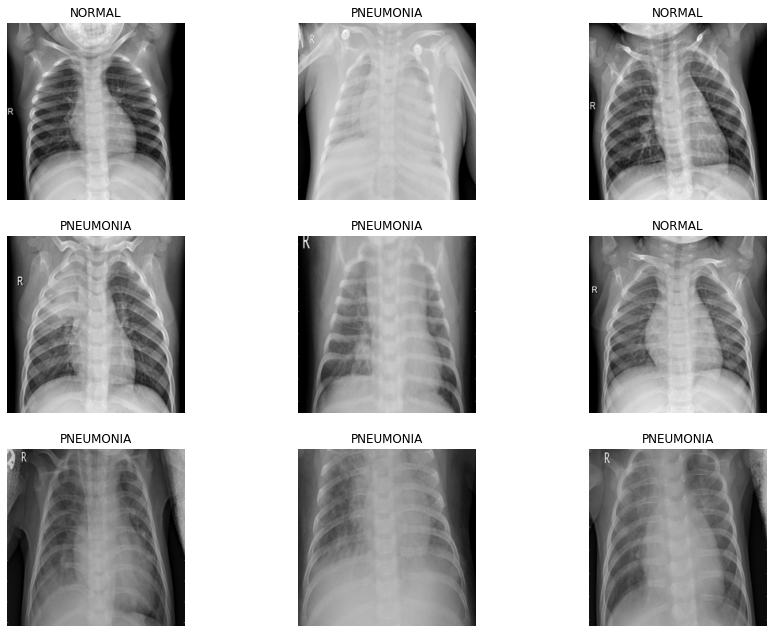

In [9]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_array, target, random_state = 43, test_size = 0.2, stratify=target)

In [11]:
print(X_train.shape)
print(y_train.shape)

(4684, 224, 224, 3)
(4684,)


In [12]:
pd.DataFrame(y_train).value_counts()/len(y_train)
pd.DataFrame().value_counts()/len(y_train)

Series([], dtype: float64)

In [13]:
#정규화 (0에서 1까지 픽셀값 조정)
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [14]:
encoder = LabelEncoder()

In [15]:
y_train_cat = encoder.fit_transform(y_train)
y_test_cat = encoder.fit_transform(y_test)

In [16]:
print(y_train[:3])
print(y_train_cat[:3])

['PNEUMONIA' 'NORMAL' 'NORMAL']
[1 0 0]


In [17]:
X_train_norm = X_train_norm.reshape(-1, 224, 224, 3)
X_test_norm = X_test_norm.reshape(-1, 224, 224, 3)
X_train_norm.shape

(4684, 224, 224, 3)

In [18]:
def Dnn_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [31]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model

def initialize_model():
    model = EfficientNetB7(input_shape = (224,224,3), weights='imagenet',include_top=False)
    for layer in model.layers:
          layer.trainable = False
    
    x = layers.Flatten()(model.output)
    x = layers.Dense(1000, activation='relu')(x)
    y = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=y)

    return model

In [32]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [33]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_cat,
                    batch_size=25,
                    epochs=4,
                    validation_split=0.3,
                    callbacks=[es])

for layer in model.layers[:-3]:
          layer.trainable = True


optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics="accuracy")

history = model.fit(X_train_norm, y_train_cat,
                    batch_size=25,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[es])

258080768/258076736 [==============================] - 6s 0us/step
Epoch 1/4
109/132 [=======================>......] - ETA: 6s - loss: 5.6089 - accuracy: 0.6191

KeyboardInterrupt: 

In [129]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model1 = Dnn_model()
model1 = compile_model(model1)

model2 = VGG16_model()
model2 = compile_model(model2)

es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

model_1 = KerasClassifier(build_fn = model1, epochs = 100, batch_size=16,
                    validation_split=0.3,
                    callbacks=[es])
model_1._estimator_type="classifier"
model_2 = KerasClassifier(build_fn = model2, epochs = 100, batch_size=16,
                    validation_split=0.3,
                    callbacks=[es])
model_2._estimator_type="classifier"


TypeError: Type of `metrics` argument not understood. Expected a list or dictionary, found: accuracy

In [115]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[('dm',model_1),('Vm',model_2)],
                               voting='hard')

In [116]:
history = voting_model.fit(X_train_norm, y_train_cat)

TypeError: can't pickle _thread.RLock objects

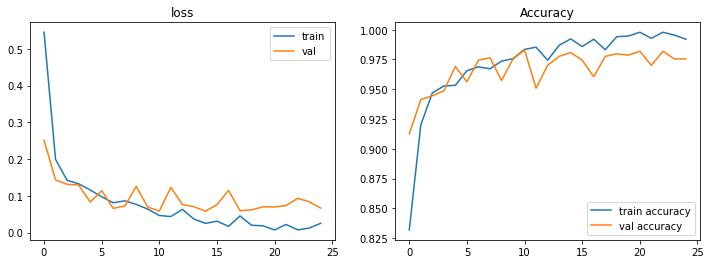

In [28]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [29]:
model.evaluate(X_test_norm, y_test_cat, verbose=0)

[0.08758781850337982, 0.9726962447166443]

In [33]:
predictions = model.predict(X_test_norm)
print(predictions)

[[9.9953198e-01]
 [9.9999964e-01]
 [9.9999475e-01]
 ...
 [6.3517690e-04]
 [3.4366548e-03]
 [1.0000000e+00]]


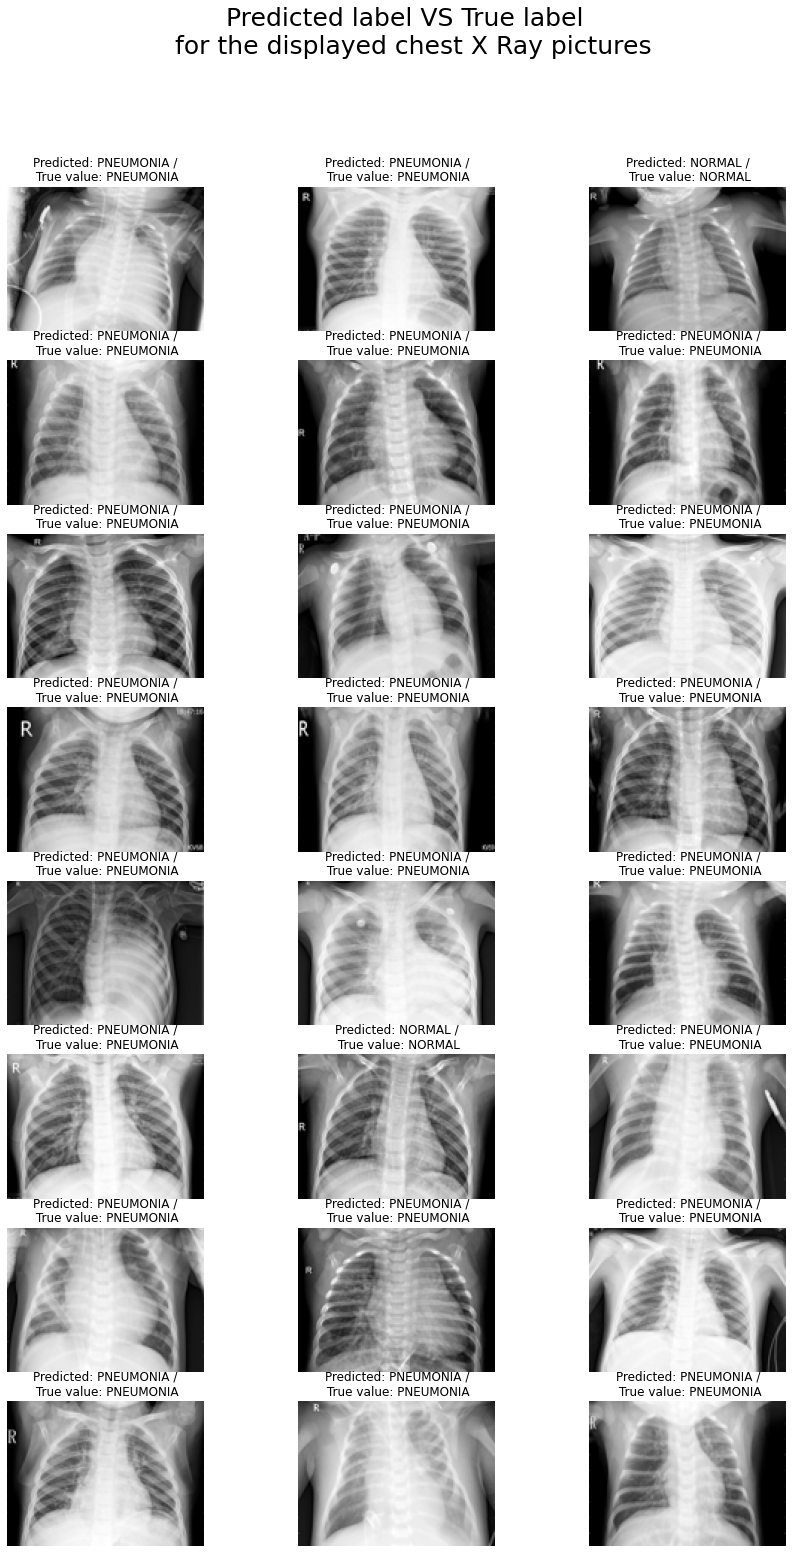

In [32]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " /\n True value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test_norm[num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;
